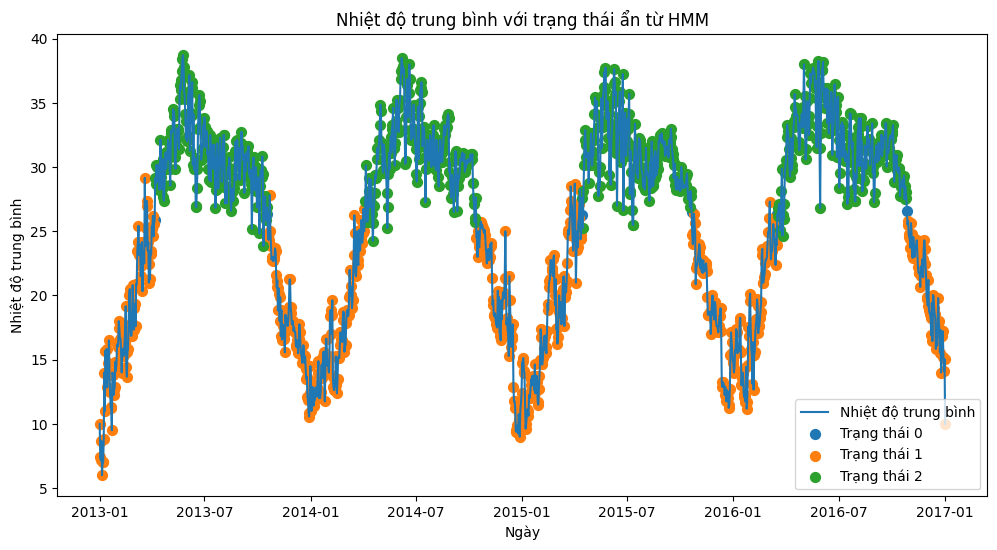

Ma trận chuyển trạng thái:
[[0.34349723 0.304714   0.35178877]
 [0.24761736 0.54213062 0.21025202]
 [0.35815238 0.26349081 0.3783568 ]]

Tham số Gaussian (mu, sigma):
Trạng thái 0: mu = 27.43, sigma = 6.37
Trạng thái 1: mu = 21.54, sigma = 7.47
Trạng thái 2: mu = 28.49, sigma = 5.73


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu
df_train = pd.read_csv('/content/DailyDelhiClimateTrain.csv')
df_train['date'] = pd.to_datetime(df_train['date'])
df_train.set_index('date', inplace=True)

# Chuẩn bị dữ liệu
X = df_train[['meantemp']].values.flatten()  # Chuyển thành mảng 1D
T = len(X)  # Độ dài chuỗi thời gian
n_states = 3  # Số trạng thái ẩn

# Khởi tạo tham số ban đầu
np.random.seed(42)
pi = np.ones(n_states) / n_states  # Phân phối trạng thái ban đầu
A = np.ones((n_states, n_states)) / n_states  # Ma trận chuyển trạng thái
mu = np.random.randn(n_states) * np.std(X) + np.mean(X)  # Trung bình Gaussian
sigma = np.ones(n_states) * np.std(X)  # Độ lệch chuẩn Gaussian

# Hàm tính xác suất quan sát P(x_t | z_t = i) (Gaussian)
def gaussian_prob(x, mu, sigma):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Thuật toán Forward (Alpha)
def forward(X, pi, A, mu, sigma):
    T = len(X)
    N = len(pi)
    alpha = np.zeros((T, N))
    log_likelihood = 0

    # Khởi tạo alpha[0]
    for i in range(N):
        alpha[0, i] = pi[i] * gaussian_prob(X[0], mu[i], sigma[i])
    alpha[0] /= np.sum(alpha[0])  # Chuẩn hóa

    # Đệ quy forward
    for t in range(1, T):
        for j in range(N):
            alpha[t, j] = sum(alpha[t-1, i] * A[i, j] * gaussian_prob(X[t], mu[j], sigma[j]) for i in range(N))
        alpha[t] /= np.sum(alpha[t])  # Chuẩn hóa
        log_likelihood += np.log(np.sum(alpha[t]))

    return alpha, log_likelihood

# Thuật toán Backward (Beta)
def backward(X, A, mu, sigma):
    T = len(X)
    N = len(A)
    beta = np.zeros((T, N))

    # Khởi tạo beta[T-1]
    beta[T-1] = 1.0 / n_states

    # Đệ quy backward
    for t in range(T-2, -1, -1):
        for i in range(N):
            beta[t, i] = sum(A[i, j] * gaussian_prob(X[t+1], mu[j], sigma[j]) * beta[t+1, j] for j in range(N))
        beta[t] /= np.sum(beta[t])  # Chuẩn hóa

    return beta

# Thuật toán EM để học tham số
def em_algorithm(X, pi, A, mu, sigma, max_iter=100, tol=1e-4):
    N = len(pi)
    T = len(X)
    log_likelihood_old = -np.inf

    for iteration in range(max_iter):
        # E-step: Tính alpha, beta, gamma, xi
        alpha, log_likelihood = forward(X, pi, A, mu, sigma)
        beta = backward(X, A, mu, sigma)

        # Tính gamma (xác suất trạng thái tại t)
        gamma = np.zeros((T, N))
        for t in range(T):
            for i in range(N):
                gamma[t, i] = alpha[t, i] * beta[t, i]
            gamma[t] /= np.sum(gamma[t])

        # Tính xi (xác suất chuyển trạng thái)
        xi = np.zeros((T-1, N, N))
        for t in range(T-1):
            for i in range(N):
                for j in range(N):
                    xi[t, i, j] = (alpha[t, i] * A[i, j] * gaussian_prob(X[t+1], mu[j], sigma[j]) * beta[t+1, j])
            xi[t] /= np.sum(xi[t])

        # M-step: Cập nhật tham số
        # Cập nhật pi
        pi = gamma[0] / np.sum(gamma[0])

        # Cập nhật A
        for i in range(N):
            for j in range(N):
                A[i, j] = np.sum(xi[:, i, j]) / np.sum(gamma[:-1, i])

        # Cập nhật mu và sigma
        for i in range(N):
            mu[i] = np.sum(gamma[:, i] * X) / np.sum(gamma[:, i])
            sigma[i] = np.sqrt(np.sum(gamma[:, i] * (X - mu[i])**2) / np.sum(gamma[:, i]))

        # Kiểm tra hội tụ
        if abs(log_likelihood - log_likelihood_old) < tol:
            break
        log_likelihood_old = log_likelihood

    return pi, A, mu, sigma, gamma

# Thuật toán Viterbi để tìm chuỗi trạng thái tối ưu
def viterbi(X, pi, A, mu, sigma):
    T = len(X)
    N = len(pi)
    V = np.zeros((T, N))
    prev = np.zeros((T, N), dtype=int)

    # Khởi tạo
    for i in range(N):
        V[0, i] = np.log(pi[i]) + np.log(gaussian_prob(X[0], mu[i], sigma[i]))

    # Đệ quy
    for t in range(1, T):
        for j in range(N):
            prob = V[t-1] + np.log(A[:, j]) + np.log(gaussian_prob(X[t], mu[j], sigma[j]))
            V[t, j] = np.max(prob)
            prev[t, j] = np.argmax(prob)

    # Backtracking
    states = np.zeros(T, dtype=int)
    states[T-1] = np.argmax(V[T-1])
    for t in range(T-2, -1, -1):
        states[t] = prev[t+1, states[t+1]]

    return states

# Huấn luyện mô hình
pi, A, mu, sigma, gamma = em_algorithm(X, pi, A, mu, sigma)

# Dự đoán trạng thái ẩn bằng Viterbi
hidden_states = viterbi(X, pi, A, mu, sigma)

# Thêm trạng thái ẩn vào dataframe
df_train['Hidden_State'] = hidden_states

# Trực quan hóa
plt.figure(figsize=(12, 6))
plt.plot(df_train.index, df_train['meantemp'], label='Nhiệt độ trung bình')
for state in range(n_states):
    mask = df_train['Hidden_State'] == state
    plt.scatter(df_train.index[mask], df_train['meantemp'][mask], label=f'Trạng thái {state}', s=50)
plt.title('Nhiệt độ trung bình với trạng thái ẩn từ HMM')
plt.xlabel('Ngày')
plt.ylabel('Nhiệt độ trung bình')
plt.legend()
plt.show()

# In ma trận chuyển trạng thái
print("Ma trận chuyển trạng thái:")
print(A)

# In tham số Gaussian
print("\nTham số Gaussian (mu, sigma):")
for i in range(n_states):
    print(f"Trạng thái {i}: mu = {mu[i]:.2f}, sigma = {sigma[i]:.2f}")